# CS203 Lab 5
**Team Members:**
1. Maharshi Patel(24210059)
2. Saravanan S(24210090)

In [3]:
#Installing dependencies
!pip install --upgrade augly
!pip install nlpaug
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 21.1 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=63e9d86fe79de4912848769676f82e59cc2d023d631e9aa923e1ccdc72c1a9d3
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built iopath
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 30.2 MB/s eta 0:00:00


In [4]:
#Importing librries
import os
import random
import shutil
import glob
from sklearn.model_selection import train_test_split
import augly.image as imaugs
import augly.utils as utils
from PIL import Image
import numpy as np
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm


## Task 1: Data Augmentation



**Download the dataset and create a train and test set (train-test ratio should be 80:20%).**

In [6]:
# Define dataset paths
DATASET_PATH = "dataset"
TRAIN_PATH = "Train"
TEST_PATH = "Test"
AUGMENTED_TRAIN_PATH = "Aug_train"

# Create train and test directories
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(AUGMENTED_TRAIN_PATH, exist_ok=True)

# Load image paths
image_paths = glob.glob(os.path.join(DATASET_PATH, "*.jpg"))

# Extract labels from filenames
cats = [path for path in image_paths if "cat" in os.path.basename(path)]
dogs = [path for path in image_paths if "dog" in os.path.basename(path)]

# Ensure equal distribution in training set

cats_train, cats_test = train_test_split(cats, test_size=0.2, random_state=1)
dogs_train, dogs_test = train_test_split(dogs, test_size=0.2, random_state=1)

train_paths = cats_train + dogs_train
test_paths = cats_test + dogs_test
train_labels = ["cat"] * len(cats_train) + ["dog"] * len(dogs_train)
test_labels = ["cat"] * len(cats_test) + ["dog"] * len(dogs_test)

# Move images to respective directories
def move_files(file_paths, labels, destination):
    for file_path, label in zip(file_paths, labels):
        label_path = os.path.join(destination, label)
        os.makedirs(label_path, exist_ok=True)
        shutil.copy(file_path, os.path.join(label_path, os.path.basename(file_path)))

move_files(train_paths, train_labels, TRAIN_PATH)
move_files(train_paths, train_labels, AUGMENTED_TRAIN_PATH)
move_files(test_paths, test_labels, TEST_PATH)

print('total training samples are', len(train_paths))




total training samples are 112


**Data Augumentation on Train set**

In [7]:
# Define augmentation function

def augment_image(image_path):
    image = Image.open(image_path).convert("RGB")

    augmentations = [
        imaugs.Rotate(degrees=random.uniform(-30, 30)),
        imaugs.Blur(radius=random.uniform(1, 3)),
        imaugs.Crop(random.uniform(0.1, 0.3)),
        imaugs.Sharpen(factor=random.uniform(1.5, 2.5)),
        imaugs.Brightness(factor=random.uniform(0.5, 1.5)),
        imaugs.Contrast(factor=random.uniform(0.5, 1.5)),
        imaugs.Saturation(factor=random.uniform(0.5, 1.5)),
        imaugs.Pixelization(ratio=random.uniform(0.1, 0.3)),
    ]

    augmented_images = []
    for _ in range(2):  # Generate twice the train set size
        random.shuffle(augmentations)  # Ensure different sequence
        aug_pipeline = imaugs.Compose(augmentations[:3])  # Select 3 random augmentations
        augmented_image = aug_pipeline(image)
        augmented_images.append(augmented_image)

    return augmented_images

# Augment the train set
train_images = glob.glob(os.path.join(AUGMENTED_TRAIN_PATH, "*/*.jpg"))

for img_path in train_images:
    label = "cat" if "cat" in os.path.basename(img_path) else "dog"
    augmented_images = augment_image(img_path)
    base_name = os.path.basename(img_path).split(".")[0]

    label_dir = os.path.join(AUGMENTED_TRAIN_PATH, label)  # Save augmented images in train set
    os.makedirs(label_dir, exist_ok=True)

    for idx, aug_img in enumerate(augmented_images):
        save_path = os.path.join(label_dir, f"{base_name}_aug{idx}.jpg")
        aug_img.save(save_path)

# Dataset statistics
original_train_count = len(train_images)
augmented_train_count = len(glob.glob(os.path.join(AUGMENTED_TRAIN_PATH, "*/*.jpg"))) - original_train_count
test_count = len(glob.glob(os.path.join(TEST_PATH, "*/*.jpg")))

dataset_stats = {
    "Original Train Set": original_train_count,
    "Augmented Train Set": augmented_train_count,
    "Final Train Set (Original + Augmented)": original_train_count + augmented_train_count,
    "Test Set": test_count
}

original_train_count_cats = len(glob.glob(os.path.join(TRAIN_PATH, "cat/*.jpg")))
augmented_train_count_cats = len(glob.glob(os.path.join(AUGMENTED_TRAIN_PATH, "cat/*.jpg"))) - original_train_count_cats
test_count_cats = len(glob.glob(os.path.join(TEST_PATH, "cat/*.jpg")))

original_train_count_dogs = len(glob.glob(os.path.join(TRAIN_PATH, "dog/*.jpg")))
augmented_train_count_dogs = len(glob.glob(os.path.join(AUGMENTED_TRAIN_PATH, "dog/*.jpg"))) - original_train_count_dogs
test_count_dogs = len(glob.glob(os.path.join(TEST_PATH, "dog/*.jpg")))

dataset_stats = {
    "Original Train Set": original_train_count,
    "Augmented Train Set": augmented_train_count,
    "Final Train Set (Original + Augmented)": original_train_count + augmented_train_count,
    "Test Set": test_count
}
dataset_stats_cats = {
    "Original Train Set": original_train_count_cats,
    "Augmented Train Set": augmented_train_count_cats,
    "Final Train Set (Original + Augmented)": original_train_count_cats + augmented_train_count_cats,
    "Test Set": test_count_cats
}
dataset_stats_dogs = {
    "Original Train Set": original_train_count_dogs,
    "Augmented Train Set": augmented_train_count_dogs,
    "Final Train Set (Original + Augmented)": original_train_count_dogs + augmented_train_count_dogs,
    "Test Set": test_count_dogs
}
print("Dataset Statistics:")
for key, value in dataset_stats.items():
    print(f"{key}: {value}")

print("/n Dataset Statistics(Cats):")
for key, value in dataset_stats_cats.items():
    print(f"{key}: {value}")

print("/n Dataset Statistics(Dogss):")
for key, value in dataset_stats_dogs.items():
    print(f"{key}: {value}")

Dataset Statistics:
Original Train Set: 112
Augmented Train Set: 224
Final Train Set (Original + Augmented): 336
Test Set: 28
/n Dataset Statistics(Cats):
Original Train Set: 56
Augmented Train Set: 112
Final Train Set (Original + Augmented): 168
Test Set: 14
/n Dataset Statistics(Dogss):
Original Train Set: 56
Augmented Train Set: 112
Final Train Set (Original + Augmented): 168
Test Set: 14


**Visualizing the data distribution using Bar Graphs**

In [8]:
import matplotlib.pyplot as plt
import numpy as np
def plot_bar_graph(stats,xlabel,title):

  categories = []
  values = []
  for key, value in stats.items():
    categories.append(key)
    values.append(value)

  # Create bar graph
  fig, ax = plt.subplots(figsize=(12, 6))
  bars = ax.bar(categories, values, color='skyblue',width=0.6)

  # Add value labels on top of each bar
  ax.bar_label(bars, fmt='%.0f', padding=3)

  # Customize the graph
  ax.set_xlabel(xlabel)
  ax.set_ylabel('No. of Images')
  ax.set_title(title)

  # Add grid lines for better readability
  ax.grid(axis='y', linestyle='--', alpha=0.7)

  # Adjust layout and display the graph
  plt.tight_layout()
  plt.show()

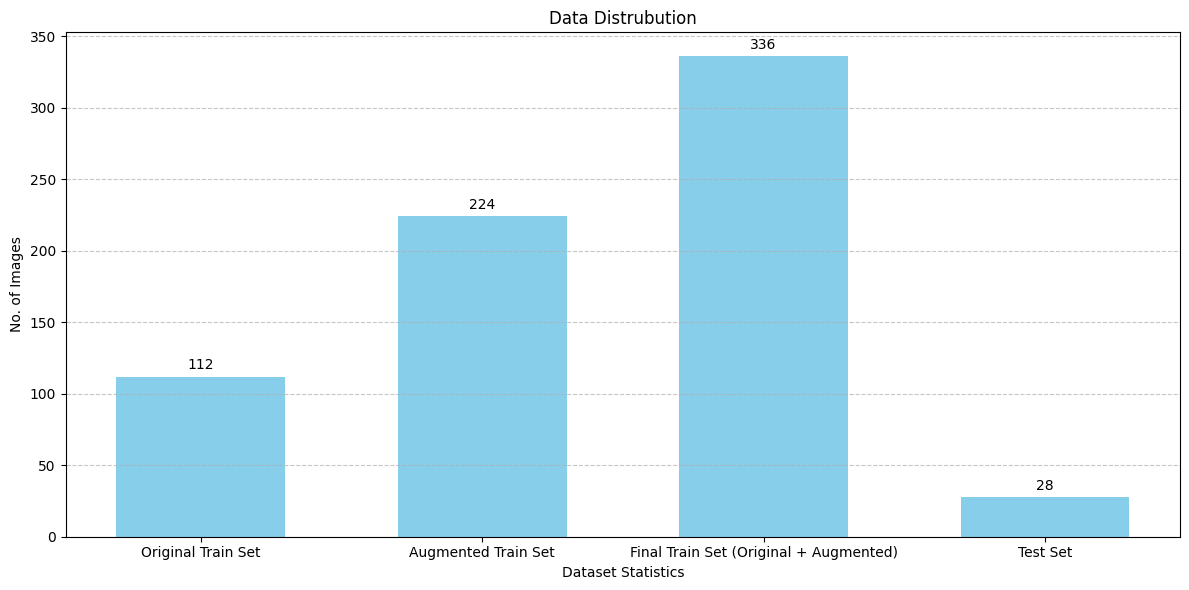

In [9]:
plot_bar_graph(dataset_stats,'Dataset Statistics','Data Distrubution')

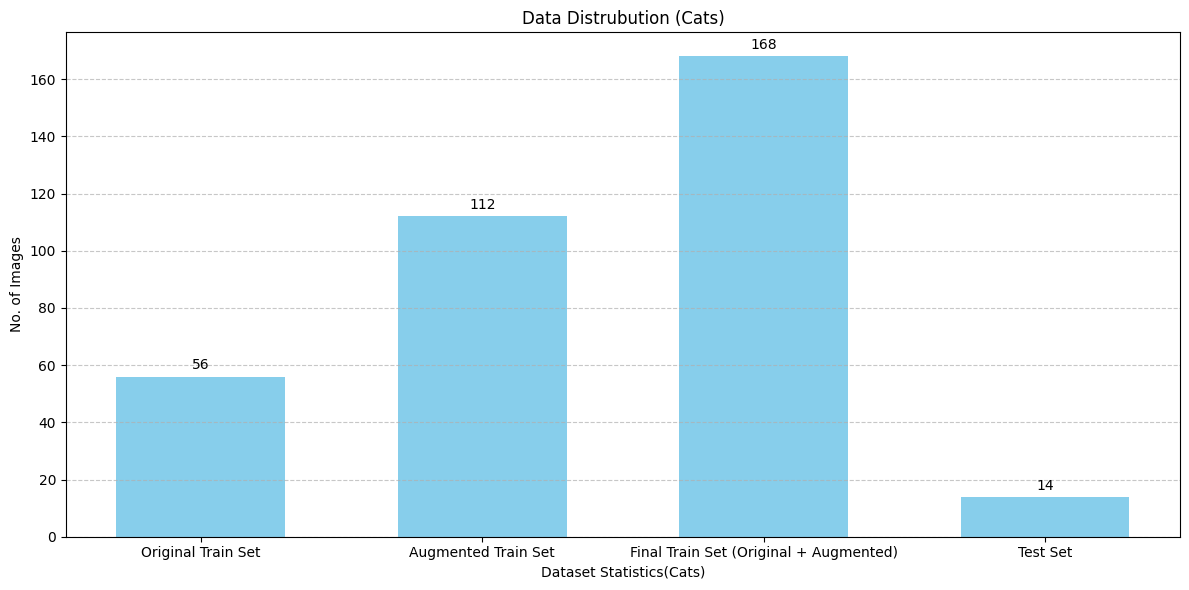

In [10]:
plot_bar_graph(dataset_stats_cats,'Dataset Statistics(Cats)','Data Distrubution (Cats)')

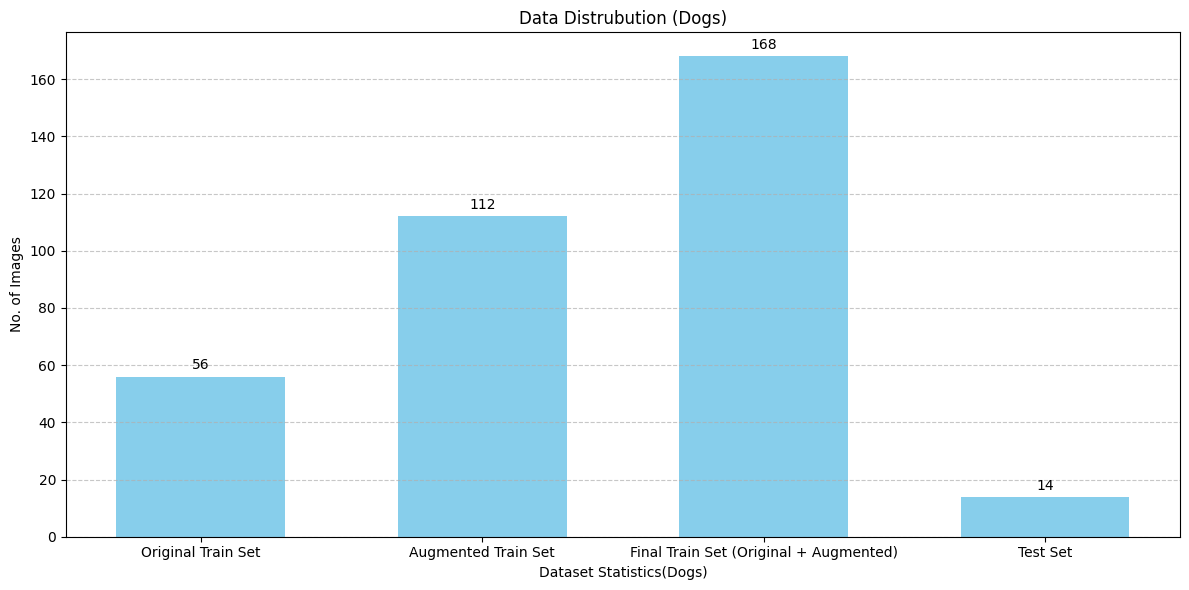

In [11]:
plot_bar_graph(dataset_stats_dogs,'Dataset Statistics(Dogs)','Data Distrubution (Dogs)')

## Task 2: Model Training

In [12]:


model_name = "microsoft/resnet-50"

# Load the pre-trained model with randomly initialized weights
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
model_aug = AutoModelForImageClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


### **Resnet Model Architecture and Parameters**
![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/resnet_architecture.png)

In [13]:
from transformers import AutoModelForImageClassification
import pandas as pd
from prettytable import PrettyTable


# Extract layers and parameters
layers = []
params = []
trainable = []

for name, param in model.named_parameters():
    layers.append(name)
    params.append(param.numel())
    trainable.append(param.requires_grad)

# Create a DataFrame to display the information
df = pd.DataFrame({
    "Layer Name": layers,
    "Number of Parameters": params,
    "Trainable": trainable
})

# Print the table using PrettyTable for better formatting
table = PrettyTable()
table.field_names = ["Layer Name", "Number of Parameters", "Trainable"]
for i in range(len(layers)):
    table.add_row([layers[i], params[i], trainable[i]])

print("Model Parameter Information (Tabular Format):")
print(table)




Model Parameter Information (Tabular Format):
+----------------------------------------------------------------+----------------------+-----------+
|                           Layer Name                           | Number of Parameters | Trainable |
+----------------------------------------------------------------+----------------------+-----------+
|          resnet.embedder.embedder.convolution.weight           |         9408         |    True   |
|         resnet.embedder.embedder.normalization.weight          |          64          |    True   |
|          resnet.embedder.embedder.normalization.bias           |          64          |    True   |
|  resnet.encoder.stages.0.layers.0.shortcut.convolution.weight  |        16384         |    True   |
| resnet.encoder.stages.0.layers.0.shortcut.normalization.weight |         256          |    True   |
|  resnet.encoder.stages.0.layers.0.shortcut.normalization.bias  |         256          |    True   |
|  resnet.encoder.stages.0.layers.0.

**Loading Data for Model Training**

In [14]:
# Define transforms (resize images to match ResNet-50 input size)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required for ResNet-50
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

class DogsCatsDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = 0 if "cat" in self.image_paths[idx] else 1  # 0 for cats, 1 for dogs
        return image, label

# Load train and test images
train_images = glob.glob("Train/*/*.jpg")
aug_train_images = glob.glob("Aug_train/*/*.jpg")
test_images = glob.glob("Test/*/*.jpg")

train_labels = [0 if "cat" in img else 1 for img in train_images]
aug_train_labels = [0 if "cat" in img else 1 for img in aug_train_images]
test_labels = [0 if "cat" in img else 1 for img in test_images]





### Train model(created in the above point) on a downloaded dataset, without augmentation.Get the precision, recall, F1 score, and accuracy of both the models on the test set.


In [15]:
# Create datasets and dataloaders
train_dataset = DogsCatsDataset(train_images, train_labels, transform)
test_dataset = DogsCatsDataset(test_images, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.6839
Epoch 2/20, Loss: 0.6657
Epoch 3/20, Loss: 0.6344
Epoch 4/20, Loss: 0.6177
Epoch 5/20, Loss: 0.6052
Epoch 6/20, Loss: 0.5617
Epoch 7/20, Loss: 0.5433
Epoch 8/20, Loss: 0.5224
Epoch 9/20, Loss: 0.4923
Epoch 10/20, Loss: 0.4773
Epoch 11/20, Loss: 0.4459
Epoch 12/20, Loss: 0.4170
Epoch 13/20, Loss: 0.3924
Epoch 14/20, Loss: 0.3722
Epoch 15/20, Loss: 0.3253
Epoch 16/20, Loss: 0.3066
Epoch 17/20, Loss: 0.2773
Epoch 18/20, Loss: 0.2660
Epoch 19/20, Loss: 0.2381
Epoch 20/20, Loss: 0.2061


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9643
Precision: 0.9333
Recall: 1.0000
F1 Score: 0.9655


### Train model(created in the first point) on a downloaded dataset with augmentation. Get the precision, recall, F1 score, and accuracy of both the models on the test set.


In [17]:
# Create datasets and dataloaders
aug_train_dataset = DogsCatsDataset(aug_train_images, aug_train_labels, transform)
test_dataset = DogsCatsDataset(test_images, test_labels, transform)

aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_aug.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in tqdm(range(num_epochs)):
    model_aug.train()
    running_loss = 0.0

    for images, labels in aug_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.9410
Epoch 2/20, Loss: 0.9490
Epoch 3/20, Loss: 0.9421
Epoch 4/20, Loss: 0.9408
Epoch 5/20, Loss: 0.9417
Epoch 6/20, Loss: 0.9484
Epoch 7/20, Loss: 0.9506
Epoch 8/20, Loss: 0.9373
Epoch 9/20, Loss: 0.9357
Epoch 10/20, Loss: 0.9473
Epoch 11/20, Loss: 0.9380
Epoch 12/20, Loss: 0.9395
Epoch 13/20, Loss: 0.9407
Epoch 14/20, Loss: 0.9580
Epoch 15/20, Loss: 0.9460
Epoch 16/20, Loss: 0.9516
Epoch 17/20, Loss: 0.9354
Epoch 18/20, Loss: 0.9489
Epoch 19/20, Loss: 0.9492
Epoch 20/20, Loss: 0.9482


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

model_aug.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_aug(images).logits
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.5714
Precision: 0.5500
Recall: 0.7857
F1 Score: 0.6471


### **Documentation about results**



* We can observe from the metrics we got, Model with Data Augumentation struggles to learn quickly than its counterpart.

* On the other hand the Model training with orginal data seems to be overfitting, which is being avoided using Data Augmentation.

* With the increase in number of epochs, both the models are capable of reducing the losses even more, since the convergence or saturation point is not met yet.

* We can see that the Recall is 1 for the first model (trained on orginal dataset) which means the model correctly classifies all the dogs as dogs.This unwanted overfitting is reduced by using Data Augumentation.

